In [106]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


In [107]:
!pip install textdistance

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
import optuna
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
from scipy.spatial.distance import jaccard
import textdistance
import os

> # Load Dataset 

In [109]:
df = pd.read_csv('/kaggle/input/quora-question-pairs/train.csv.zip', compression='zip')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [111]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [112]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [113]:
df.is_duplicate.value_counts()

is_duplicate
0    255024
1    149263
Name: count, dtype: int64

<Axes: ylabel='count'>

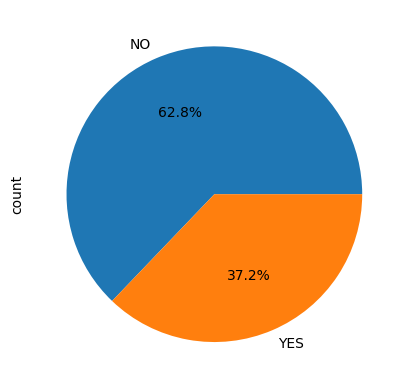

In [114]:
df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)  # Use only 50% of the dataset
df.is_duplicate.value_counts().plot(kind='pie', labels=['NO', 'YES'], autopct='%1.1f%%')

> # Data Preprocessing using SpaCy

In [115]:
nlp = spacy.load('en_core_web_sm')

def clean_text_spacy(text):
    doc = nlp(str(text).lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [116]:
data = df[:10]
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
1,224279,332326,332327,Will a breathing treatment help a cough?,How can I help someone that is unconscious but...,0
2,252452,336023,366789,Is Kellyanne Conway annoying in your opinion?,Did Kellyanne Conway really imply that we shou...,0
3,174039,268330,268331,How do you rate (1-10) and review Maruti Baleno?,What career options does one have after comple...,0
4,384863,28901,233483,What are some good books on marketing?,What are some of the best books ever written a...,1


In [117]:
data.shape

(10, 6)

In [118]:
data['question1'] = data['question1'].apply(lambda x: clean_text_spacy(x) if pd.notnull(x) else '')
data['question2'] = data['question2'].apply(lambda x: clean_text_spacy(x) if pd.notnull(x) else '')

<ipython-input-118-5343bdb521e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['question1'] = data['question1'].apply(lambda x: clean_text_spacy(x) if pd.notnull(x) else '')
<ipython-input-118-5343bdb521e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['question2'] = data['question2'].apply(lambda x: clean_text_spacy(x) if pd.notnull(x) else '')


In [119]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,8067,15738,15739,play pokémon korea,play pokémon china,0
1,224279,332326,332327,breathing treatment help cough,help unconscious breathe,0
2,252452,336023,366789,kellyanne conway annoying opinion,kellyanne conway imply pay attention word come...,0
3,174039,268330,268331,rate review maruti baleno,career option complete bachelor degree distanc...,0
4,384863,28901,233483,good book marketing,good book write marketing,1


In [120]:
data.question2.values[1]

'help unconscious breathe'

In [121]:
df.question2.values[1]

'How can I help someone that is unconscious but still breathing?'

In [122]:
cleaned_file = '/kaggle/working/cleaned_quora_data.csv'
if os.path.exists(cleaned_file):
    df = pd.read_csv(cleaned_file)
    print("Loaded cleaned data from file.")
else:
    df['question1'] = df['question1'].apply(lambda x: clean_text_spacy(x) if pd.notnull(x) else '')
    df['question2'] = df['question2'].apply(lambda x: clean_text_spacy(x) if pd.notnull(x) else '')

    # Save cleaned data for future use
    df.to_csv(cleaned_file, index=False)
    print("Cleaned data saved for future use.")

Loaded cleaned data from file.


In [123]:
df.question2.values[1]

'help unconscious breathe'

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40429 entries, 0 to 40428
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            40429 non-null  int64 
 1   qid1          40429 non-null  int64 
 2   qid2          40429 non-null  int64 
 3   question1     40352 non-null  object
 4   question2     40352 non-null  object
 5   is_duplicate  40429 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.9+ MB


In [125]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40325 entries, 0 to 40428
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            40325 non-null  int64 
 1   qid1          40325 non-null  int64 
 2   qid2          40325 non-null  int64 
 3   question1     40325 non-null  object
 4   question2     40325 non-null  object
 5   is_duplicate  40325 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.2+ MB


In [126]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,8067,15738,15739,play pokémon korea,play pokémon china,0
1,224279,332326,332327,breathing treatment help cough,help unconscious breathe,0
2,252452,336023,366789,kellyanne conway annoying opinion,kellyanne conway imply pay attention word come...,0
3,174039,268330,268331,rate review maruti baleno,career option complete bachelor degree distanc...,0
4,384863,28901,233483,good book marketing,good book write marketing,1


In [127]:
# df = df.sample(frac=0.4, random_state=42).reset_index(drop=True)  # Use only 40% of the dataset

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40325 entries, 0 to 40428
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            40325 non-null  int64 
 1   qid1          40325 non-null  int64 
 2   qid2          40325 non-null  int64 
 3   question1     40325 non-null  object
 4   question2     40325 non-null  object
 5   is_duplicate  40325 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.2+ MB


In [129]:
df.is_duplicate.value_counts()

is_duplicate
0    25318
1    15007
Name: count, dtype: int64

> # Feature Engineering

In [130]:
def safe_set(text):
    """Convert text into a set of words safely."""
    return set(text.split()) if isinstance(text, str) else set()

# Word-based Features
df['q1_word_count'] = df['question1'].apply(lambda x: len(x.split()))
df['q2_word_count'] = df['question2'].apply(lambda x: len(x.split()))
df['common_word_count'] = df.apply(lambda x: len(safe_set(x['question1']) & safe_set(x['question2'])), axis=1)
df['word_share'] = df['common_word_count'] / (df['q1_word_count'] + df['q2_word_count'] + 1e-6)

# Similarity-based Features
df['jaccard'] = df.apply(lambda x: len(safe_set(x['question1']) & safe_set(x['question2'])) / 
                                      (len(safe_set(x['question1']) | safe_set(x['question2'])) + 1e-6), axis=1)
df['levenshtein'] = df.apply(lambda x: textdistance.levenshtein.normalized_distance(x['question1'], x['question2']), axis=1)


In [131]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_word_count', 'q2_word_count', 'common_word_count', 'word_share',
       'jaccard', 'levenshtein'],
      dtype='object')

In [132]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_word_count,q2_word_count,common_word_count,word_share,jaccard,levenshtein
0,8067,15738,15739,play pokémon korea,play pokémon china,0,3,3,2,0.333333,0.500000,0.222222
1,224279,332326,332327,breathing treatment help cough,help unconscious breathe,0,4,3,1,0.142857,0.166667,0.900000
2,252452,336023,366789,kellyanne conway annoying opinion,kellyanne conway imply pay attention word come...,0,4,10,2,0.142857,0.166667,0.630769
3,174039,268330,268331,rate review maruti baleno,career option complete bachelor degree distanc...,0,4,11,0,0.000000,0.000000,0.814815
4,384863,28901,233483,good book marketing,good book write marketing,1,3,4,3,0.428571,0.750000,0.240000


In [133]:
tfidf = TfidfVectorizer(max_features=5000)
q1_tfidf = tfidf.fit_transform(df['question1'])
q2_tfidf = tfidf.transform(df['question2'])

In [136]:
X = hstack((q1_tfidf, q2_tfidf, df[['q1_word_count', 'q2_word_count', 'common_word_count', 'word_share', 'jaccard', 'levenshtein']].values))
y = df['is_duplicate'].values

> # Hyperparameter Tuning with Optuna

In [138]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
    }
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

> # Visualizations

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


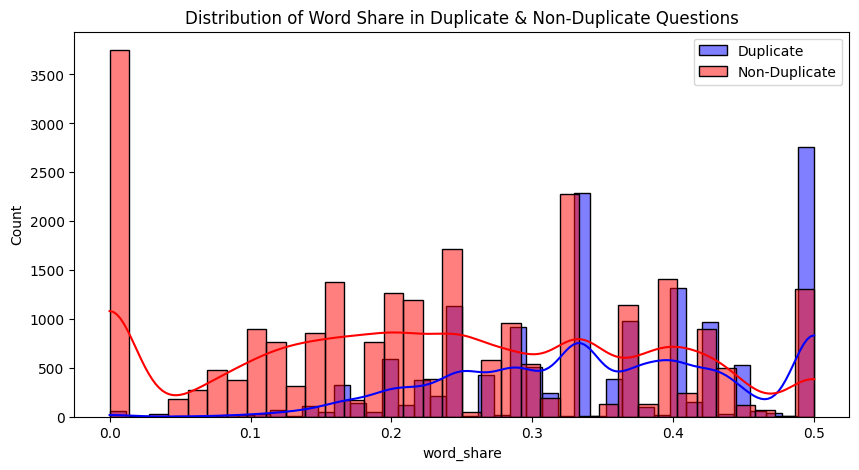

In [139]:
plt.figure(figsize=(10,5))
sns.histplot(df['word_share'][df['is_duplicate'] == 1], color='blue', kde=True, label='Duplicate')
sns.histplot(df['word_share'][df['is_duplicate'] == 0], color='red', kde=True, label='Non-Duplicate')
plt.legend()
plt.title("Distribution of Word Share in Duplicate & Non-Duplicate Questions")
plt.show()

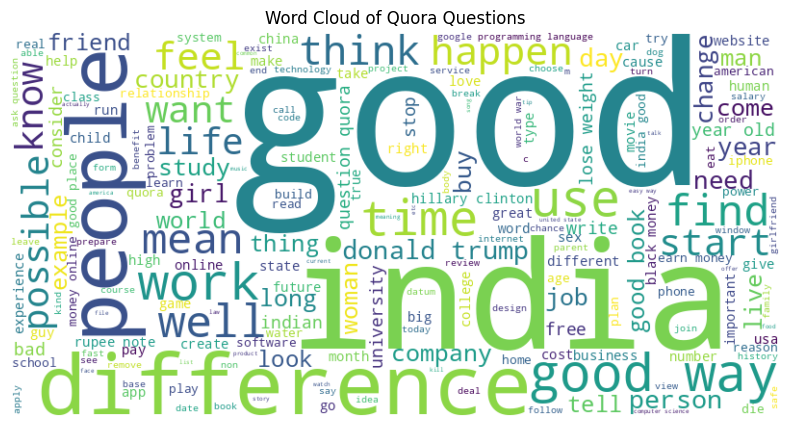

In [140]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df['question1'] + " " + df['question2']))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Quora Questions")
plt.show()

> # Split Data

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

> # Train Models

In [142]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
}

In [143]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.7569
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      5018
           1       0.70      0.63      0.66      3047

    accuracy                           0.76      8065
   macro avg       0.74      0.73      0.74      8065
weighted avg       0.75      0.76      0.75      8065

Random Forest Accuracy: 0.7697
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      5018
           1       0.75      0.59      0.66      3047

    accuracy                           0.77      8065
   macro avg       0.76      0.73      0.74      8065
weighted avg       0.77      0.77      0.76      8065

XGBoost Accuracy: 0.7586
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      5018
           1       0.72      0.59      0.65      3047

    accuracy                           0.76      8065
   macro avg       0.75      0.73  

> # Compare Models

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


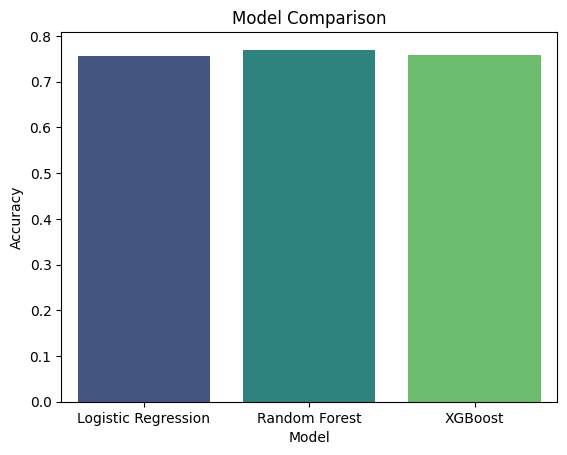

In [144]:
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()

> # Best Model Selection

In [145]:
best_model = max(results, key=results.get)
print(f"Best Model: {best_model} with Accuracy: {results[best_model]:.4f}")

Best Model: Random Forest with Accuracy: 0.7697


In [146]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print(f"Best Parameters: {study.best_params}")

[I 2025-02-09 14:53:47,273] A new study created in memory with name: no-name-1101fd72-3932-4852-9c04-155e687c408e
<ipython-input-138-79cb95845e34>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
[I 2025-02-09 14:56:21,344] Trial 0 finished with value: 0.7496590204587724 and parameters: {'n_estimators': 418, 'max_depth': 12, 'learning_rate': 0.01449354854288951}. Best is trial 0 with value: 0.7496590204587724.
<ipython-input-138-79cb95845e34>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
[I 2025-02-09 14:57:30,452] Trial 1 fini

Best Parameters: {'n_estimators': 228, 'max_depth': 13, 'learning_rate': 0.15268437030561596}
